In [333]:
import numpy as np
import pandas as pd
import gdal
import glob
import os
import datetime
from scipy.interpolate import griddata
import re
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [174]:
# define variables
TA_da = None
EVI_da = None
LST_Day_da = None
LST_Night_da = None
MIN_PATCH_SIZE = 3
MAX_PATCH_SIZE = 750

In [2]:
# Collect Files
FILE_DICT = {
    'EVI' : glob.glob('MODIS_NDVI/MOD13*EVI*.tif'),
    'EVI_pixel' : glob.glob('MODIS_NDVI/*pixel_reliability*.tif'),
    'EVI_QC' : glob.glob('MODIS_NDVI/*VI_Quality*.tif'),
    'TA' : glob.glob('MODIS_TA/MOD14*FireMask*.tif'),
    'TA_QC' : glob.glob('MODIS_TA/*QA*.tif'),
    'LST_Day' : glob.glob('MODIS_LST_Day/*LST_Day*.tif'),
    'LST_Day_QC' : glob.glob('MODIS_LST_Day/*QC_Day*.tif'),
    'LST_Night' : glob.glob('MODIS_LST_Night/*LST_Night*.tif'),
    'LST_Night_QC' : glob.glob('MODIS_LST_Night/*QC_Night*.tif')
}

In [268]:
# Open files as xarray DataArrays
def open_xarray(data, is_qc=False):
    """
    Opens dataset as an xarray DataArray.
    
    :param data: key from file_dict
    :param file_dict: dictionary of file paths
    
    :returns: xarray data structure"""
    v = FILE_DICT[data]
    pat = r'doy(\d{7})'
    da_list = []
    for fp in v:
        # extract timestamp from filepath
        time = re.findall(pat, fp)[0]
        year = int(time[:4])
        day = int(time[-3:])
        
        # open raster
        da = xr.open_rasterio(fp)
        
        # assign time coordinate to raster
        dt = (datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1))
        da = da.assign_coords(time=dt)
        
        # add current day to list of rasters
        da_list.append(da)
    # consolidate rasters
    da = xr.concat(da_list, dim='time').squeeze()
    
    # give raster a name
    da.name = data
    # apply scale factor
    da.values = da.values * eval(da.attrs['scale_factor'])
    if not is_qc:
        da.values = da.values.astype(float)
        no_data = da.attrs['nodatavals'][0]
        da.values = (np.ma.masked_equal(da.values, no_data))
    
    da = da.sortby(da.time)
    return da


def interp_da(to_interp, interp_like):
    """
    Function intended to perform temporal interpolation on the EVI data.
    
    :param to_interp: the DataArray to temporally interpolate
    :param interp_like: the DataArray with the desired temporal resolution
    
    :returns: interpolated input DA
    """
    return to_interp.interp({'time':interp_like.time}, method='linear')

In [20]:
QC_MAP = {
    'TA': [0, 4],
    'EVI': [0],
    'LST_Day': [0],
    'LST_Night': [0]
}

def filter_qa(da_name, qc_da_name):
    """
    Filters pixels from dataset based on QA info found in MODXXA2 User Guide.
    
    :param da_name: the name of the DataArray found in keys of FILE_DICT
    :param qc_da_name: the name of the QC DataArray found in the keys of FILE_DICT
    
    :returns: filtered dataset
    """
    da = open_xarray(da_name)
    qc_da = open_xarray(qc_da_name, is_qc=True)
    
    qc_filter = QC_MAP[da_name]
    
    for f in qc_filter:
        if da_name == 'TA':
            da.values[qc_da.values == f] = np.nan
        else:
            da.values[qc_da.values != f] = np.nan
    
    return da

In [ ]:
def load_datasets():
    """
    Loads all datasets, does qa filtering, and interpolates where necessary.
    Saves datasets to global variables defined at top of notebook.
    """
    global TA_da
    global EVI_da
    global LST_Day_da
    global LST_Night_da
    
    TA_da = filter_qa('TA', 'TA_QC')
    print('TA loaded')
    LST_Day_da = filter_qa('LST_Day', 'LST_Day_QC')
    print('LST Day loaded')
    LST_Night_da = filter_qa('LST_Night', 'LST_Night_QC')
    print('LST Night loaded')
    EVI_da = filter_qa('EVI', 'EVI_pixel')
    EVI_da = interp_da(EVI_da, TA_da)
    print('EVI loaded')

In [269]:
load_datasets()

TA loaded
LST Day loaded
LST Night loaded
EVI loaded


In [305]:
def pixel_good(time, pixel):
    """
    Determines if a pixel is acceptable to add to a non-fire pixel patch.
    (ie not NaN in any raster and not a fire pixel (7,8,9)).
    
    :param time: the time index of the pixel
    :param pixel: the spatial index to check
    :returns: True or False (pixel is acceptable)
    """
    # check if pixel is a fire pixel
    if TA_da.values[time][pixel] in [7, 8, 9]:
        return False
    
    # check if pixel is NaN
    for da in [TA_da, EVI_da, LST_Day_da, LST_Night_da]:
        if np.isnan(da.values[time][pixel]):
            return False
    
    # pixel passed tests
    return True

def find_patch(time, curr_pix, patch, found, frontier, patch_size):
    """
    Finds a non-fire patch of pixels as an instance of no fire.
    
    :param time: raster date index to extract
    :param curr_pix: current pixel being processed
    :param patch: the patch of pixles being generated, starts as empty list
    :param found: list of visited index tuples
    :param frontier: list of pixels to invesigate, pass empty to start
    :param patch_size: number of pixels to be found for this patch
    
    :returns: list of tuples of indices in patch
    """
    # add pixel to patch
    patch.append(curr_pix)
        
    #stop when patch is appropriately sized
    if len(patch) >= patch_size:
        return patch
    
    #explore pixel neighbors
    for i in range(-1,2,1):
        for j in range(-1,2,1):
            neighbor = (curr_pix[0]+i, curr_pix[1]+j)
            # only examine pixel if not already checked
            if (neighbor not in found) and pixel_good(time, neighbor):
                frontier.append(neighbor)
                found.append(neighbor)
                
    # if no more valid pixels to check, exit
    if len(frontier) == 0:
        return patch
    
    # examine next pixel in queue
    next_pix = frontier.pop(0)
    
    # recurse
    return find_patch(time, next_pix, patch, found, frontier, patch_size)

In [307]:
def find_non_fire_patches(load_datasets=False):
    """
    Find set of non-fire patches for each day in time-series.
    
    :param load_datasets: pass True if datasets have not already been loaded
    
    :returns: dictionary of patch indices (date -> list of patches)
    """
    # load datasets
    if load_datasets:
        load_datasets()
    
    # initialize storage
    patches = {}
    
    # save dimensions of a raster
    dim1 = TA_da.shape[1]
    dim2 = TA_da.shape[2]
    
    for time in np.arange(TA_da.shape[0]):
        curr_patches = []
        found = []
        
        # find this many distinct patches for this date 
        for _ in range(np.random.choice(np.arange(2,6), p = [0.35, 0.35, 0.15, 0.15])):
                
            # choose random patch size
            patch_size = 0
            while (patch_size < MIN_PATCH_SIZE) or (patch_size > MAX_PATCH_SIZE):
                # to see sample distribution generate 1000 samples and plot
                patch_size = int(np.random.lognormal(2, 1.75))
            
            # generate random start point that hasn't yet been chosen
            i, j = 0, 0
            while (not pixel_good(time, (i,j))) or ((i,j) in found):
                i = np.random.choice(np.arange(dim1))
                j = np.random.choice(np.arange(dim2))
            start = (i,j)

            # find a patch
            found.append(start)
            patch = find_patch(time, start, [], found, [], patch_size)
            curr_patches.append(patch)
            found.extend(patch)
            
        # save patches to dictionary
        patches[TA_da.time.values[time]] = curr_patches
        
    return patches

In [287]:
i, j = 0, 0
while not pixel_good(0, (i,j)):
    i = np.random.choice(np.arange(LST_Day_da.shape[1]))
    j = np.random.choice(np.arange(LST_Day_da.shape[2]))
    
start = (i,j)
print(start)
start = (14, 1273)
130
test = find_patch(0, start, [], [], [], 130)
print('Done.')

(459, 782)
Done.


In [93]:
ix = ([p[0] for p in test], [p[1] for p in test])

In [304]:
patches = find_non_fire_patches()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [331]:
def extract_data_from_patches(patches):
    # extract dimensions of a pixel
    pixel_length = TA_da.attrs['transform'][0]  # length of a pixel in meters
    rows = []
    
    # iterate through patches dict
    for k, v in patches.items():
        time = k
        # iterate through patches 
        for patch in v:
            # extract relevant values from each patch
            curr_row = {}
            ix = ([p[0] for p in patch], [p[1] for p in patch])
            curr_row['time'] = time
            curr_row['area'] = pixel_length**2 * len(patch)
            curr_row['lst_day'] = np.mean(LST_Day_da.sel(time=time).values[ix])
            curr_row['lst_night'] = np.mean(LST_Night_da.sel(time=time).values[ix])
            curr_row['evi'] = np.mean(EVI_da.sel(time=time).values[ix])
            curr_row['class'] = 'no_fire'
            rows.append(curr_row)
        
    return pd.DataFrame(rows)

In [344]:
df = extract_data_from_patches(patches)
df.to_csv('non_fire.csv', index=False)

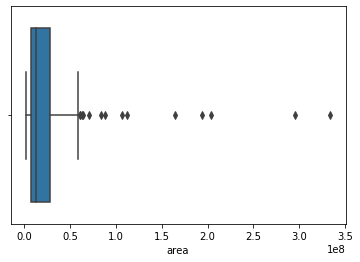

In [343]:
import seaborn as sns
sns.boxplot(df.area)